# Imports

First we get all the imports we need to do some data discovery.
I put comments on what each is used for and why I need it

In [65]:
import pandas as pd
import numpy as np

# we need regex for data cleansing
import re

# import matplotlib and seaborn for viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#import for machine learning
from sklearn.ensemble import RandomForestRegressor
 

---
# Data Discovery

Here we take a look at the data we are working with. Once we have a good understanding of the data (distribution of values, definition of the columns, etc) we will go through the data and clean the data so its consumable by our ML algos.

First we will load up just the training set and take a look at the data with `head()` and have it summarized using pandas `describe()`

Then we will start to clean the data. Typically we only need to do this once but since the testing data set and the training data set are separated, we will keep track of everything we did and do it to the test set as well (in a seperate cell, so we can see it all in one place).

## Data Dictionary (provided by Kaggle)

|Variable|Definition       |Key                          |
|--------|-----------------|-----------------------------|
|survival|Survival         |0 = No<br>1 = Yes            |
|pclass  |Ticket class     |1 = 1st<br>2 = 2nd<br>3 = 3rd|
|sex     |Sex              |                             |	
|Age     |Age in years     |                             |
|sibsp   |# of siblings/spouses aboard the Titanic|      |
|parch   |# of parents/children aboard the Titanic|      |
|ticket  |Ticket number    |                             |	
|fare    |Passenger fare   |                             |	
|cabin   |Cabin number     |                             |
|embarked|Port of Embarkation|C = Cherbourg<br>Q = Queenstown<br>S = Southampton|


In [66]:
train = pd.read_csv('train.csv', index_col='PassengerId')
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [67]:
train.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Davidson, Mr. Thornton",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [68]:
# we take a look the df to look at all the rows that contain at least one NaN
# how many rows do we have NaN's in?
print(train[train.isnull().any(axis=1)].count(), "\n")

#Next, which columns have the most NaN's
print(train.isnull().sum())

Survived    708
Pclass      708
Name        708
Sex         708
Age         531
SibSp       708
Parch       708
Ticket      708
Fare        708
Cabin        21
Embarked    706
dtype: int64 

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


---
# Cleaning

Now we start cleaning up the data but for the train only. Here, we are taking it very slow and making sure the data looks right after each command. This will help with getting familiar with pandas.df functions.

We will go from left to right.

## Names

Since we know that your name had no bearing on your survival, we really don't care about the actual name. Instead there are data that can be teased out of the names. Specifically here we are going to extra two things:
1. Length of the names
2. Any titles in the name

### Length of names
This is easy and can be done in one line using pandas.df.apply function

### Titles in the names
This is slightly more complicated. First we define a function `get_title()` that uses regex to look for any combination of letters that is followed by a period. Next, we will take a look of the unqiue titles and organize it from there. Finally, we will index these into integer buckets so the ML algo can use it.

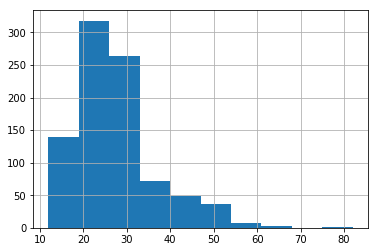

In [69]:
# grab the name length
train["NameLength"] = train["Name"].apply(len)

# lets look at the distribution of names lengths
train["Name"].apply(len).hist()

In [70]:
# define a function with regex
def get_title(name):
    # if title exists, extract and return it
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

#grab the titles
train["Title"] = train["Name"].apply(get_title)

#lets look at the count of the unique titles
train.groupby("Title").count()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameLength
Title,,,,,,,,,,,,
Capt,1,1,1,1,1,1,1,1,1,1,1,1
Col,2,2,2,2,2,2,2,2,2,1,2,2
Countess,1,1,1,1,1,1,1,1,1,1,1,1
Don,1,1,1,1,1,1,1,1,1,0,1,1
Dr,7,7,7,7,6,7,7,7,7,3,7,7
Jonkheer,1,1,1,1,1,1,1,1,1,0,1,1
Lady,1,1,1,1,1,1,1,1,1,1,1,1
Major,2,2,2,2,2,2,2,2,2,2,2,2
Master,40,40,40,40,36,40,40,40,40,7,40,40


In [71]:
# lets group everything count < 10 into Rare
train['Title'] = train['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                         'Don', 'Dr', 'Major', 'Rev',
                                         'Sir', 'Jonkheer', 'Dona'],
                                        'Rare')

# finally, we group the rest of the titles as needed
train['Title'] = train['Title'].replace(['Mlle','Ms'], 'Miss')
train['Title'] = train['Title'].replace(['Mme'], 'Mrs')

# lets now map the title to numbers
title_mapping = {"Mr": 1, "Miss": 2, "Mrs" : 3, "Master" : 4, "Rare" : 5}
train["Title"] = train["Title"].map(title_mapping)
train["Title"] = train["Title"].fillna(0)

#now we can get rid of Name
train = train.drop(columns=['Name'])

#lets take a look at the data now
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameLength,Title
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,1
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,51,3
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,2
4,1,1,female,35.0,1,0,113803,53.1000,C123,S,44,3
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,24,1


In [72]:
#next we map the male and female as well
train["Sex"] = train["Sex"].map({"male":1, "female":2})

# We don't care so much about where your cabin was but rather if
# you had a cabin at all
train['HasCabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# we dont care about the ticket number
# now we can drop both cabin and ticket
train = train.drop(columns=['Cabin', 'Ticket'])

# and the embark
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )

# Then let's take a look at it!
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameLength,Title,HasCabin
PassengerId,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0.0,23,1,0
2,1,1,2,38.0,1,0,71.2833,1.0,51,3,1
3,1,3,2,26.0,0,0,7.9250,0.0,22,2,0
4,1,1,2,35.0,1,0,53.1000,0.0,44,3,1
5,0,3,1,35.0,0,0,8.0500,0.0,24,1,0


## NaNs and SKLearn
We are planning touse sklearn to train our models. Sklearn does not take any NaN rows so we have to check to see if there are any and if so, we need to clean it up.

A quick way to check if we have any nulls is to use pandas `isnull()`

In [73]:
train.isnull().any()

Survived      False
Pclass        False
Sex           False
Age            True
SibSp         False
Parch         False
Fare          False
Embarked       True
NameLength    False
Title         False
HasCabin      False
dtype: bool

So we see that there are two columns that have null values. Let's first take a look at age and what we can do with it.

### Age

If we were creating a quick model to test for viability, I would just take the average of all the ages and fill that in for all the nulls. Here since we are taking a more nuianced approach we will bin these ages into different age groups with the Nan's taking a 0 class.

First let's take a look at the histogram of ages and define how to split it up.

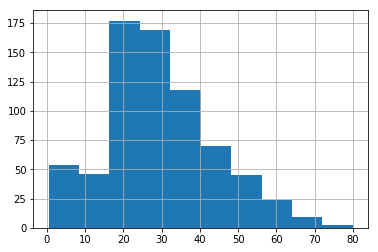

In [74]:
train['Age'].hist()

This seems pretty standard. We'll split it up as follows:
- Nan --> 0
- 0 - 18 --> 1
- 18 - 32 --> 2
- 32 - 48 --> 3
- 48 - 60 --> 4
- 60 - 90 --> 5

In [75]:
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameLength,Title,HasCabin
PassengerId,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0.0,23,1,0
2,1,1,2,38.0,1,0,71.2833,1.0,51,3,1
3,1,3,2,26.0,0,0,7.9250,0.0,22,2,0
4,1,1,2,35.0,1,0,53.1000,0.0,44,3,1
5,0,3,1,35.0,0,0,8.0500,0.0,24,1,0
6,0,3,1,NaN,0,0,8.4583,2.0,16,1,0
7,0,1,1,54.0,0,0,51.8625,0.0,23,1,1
8,0,3,1,2.0,3,1,21.0750,0.0,30,4,0
9,1,3,2,27.0,0,2,11.1333,0.0,49,3,0


In [63]:
train["Age"] = train["Age"].fillna(0)
train.loc[ train['Age'] <= 16, 'Age'] = 1
train.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
train.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
train.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
train.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

train.head(200)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameLength,Title,HasCabin
PassengerId,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0.0,23,1,0
2,1,1,2,38.0,1,0,71.2833,1.0,51,3,1
3,1,3,2,26.0,0,0,7.9250,0.0,22,2,0
4,1,1,2,35.0,1,0,53.1000,0.0,44,3,1
5,0,3,1,35.0,0,0,8.0500,0.0,24,1,0
6,0,3,1,1.0,0,0,8.4583,2.0,16,1,0
7,0,1,1,54.0,0,0,51.8625,0.0,23,1,1
8,0,3,1,1.0,3,1,21.0750,0.0,30,4,0
9,1,3,2,27.0,0,2,11.1333,0.0,49,3,0


In [54]:
train[isnull()]


/Users/dan.park/.virtualenvs/titanic/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameLength,Title,HasCabin
PassengerId,,,,,,,,,,,
22.0,1.0,2.0,1.0,34.0,0.0,0.0,13.0000,0.0,21.0,1.0,1.0
38.0,0.0,3.0,1.0,21.0,0.0,0.0,8.0500,0.0,24.0,1.0,0.0
26.0,1.0,3.0,2.0,38.0,1.0,5.0,31.3875,0.0,57.0,3.0,0.0
35.0,0.0,1.0,1.0,28.0,1.0,0.0,82.1708,1.0,23.0,1.0,0.0
35.0,0.0,1.0,1.0,28.0,1.0,0.0,82.1708,1.0,23.0,1.0,0.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54.0,1.0,2.0,2.0,29.0,1.0,0.0,26.0000,0.0,50.0,3.0,0.0
2.0,1.0,1.0,2.0,38.0,1.0,0.0,71.2833,1.0,51.0,3.0,1.0
27.0,0.0,3.0,1.0,NaN,0.0,0.0,7.2250,1.0,23.0,1.0,0.0


Now that we have train the way we want it to look, lets apply this cleansing to both train and test

In [35]:
# we make these into a list of dataframes so we can
# transform the data together. typically these would be in one
# dataframe and we would split it at the end (before training)
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')
fullData = [train, test]


# Remember, because our training set and test set
# are in separate df's we have to iterate thru fullData
# and apply all our changes from training into test
# right now, we are doing that for train but we have to go
# back and do it for all the iterators in fullData

# when you iterate thru a list and change the iterator
# it does not change the actual list so we use enumerate
# to pass the index and value and use those

for idx, val in enumerate(fullData):
    fullData[idx]['NameLength'] = val['Name'].apply(len)
    fullData[idx]['Title'] = val['Name'].apply(get_title)
    fullData[idx]['Title'] = val['Title'].replace(['Lady', 'Countess', 'Capt', 'Col','Don', 'Dr', 'Major', 'Rev','Sir', 'Jonkheer', 'Dona'],
                                                  'Rare')
    fullData[idx]['Title'] = val['Title'].replace(['Mlle','Ms'], 'Miss')
    fullData[idx]['Title'] = val['Title'].replace(['Mme'], 'Mrs')
    fullData[idx]["Title"] = train["Title"].map({"Mr": 1, "Miss": 2, "Mrs" : 3, "Master" : 4, "Rare" : 5})
    fullData[idx]["Title"] = train["Title"].fillna(0)
    fullData[idx]['Sex'] = val['Sex'].map({'male':1, 'female':2})
    fullData[idx]['HasCabin'] = val["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    fullData[idx]['Embarked'] = val['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
    fullData[idx] = val.drop(columns=['Cabin', 'Ticket', 'Name'])
    
    
train, test = fullData

# Then let's take a look at it!
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameLength,Title,HasCabin
PassengerId,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0.0,23,1,0
2,1,1,2,38.0,1,0,71.2833,1.0,51,3,1
3,1,3,2,26.0,0,0,7.9250,0.0,22,2,0
4,1,1,2,35.0,1,0,53.1000,0.0,44,3,1
5,0,3,1,35.0,0,0,8.0500,0.0,24,1,0
6,0,3,1,NaN,0,0,8.4583,2.0,16,1,0
7,0,1,1,54.0,0,0,51.8625,0.0,23,1,1
8,0,3,1,2.0,3,1,21.0750,0.0,30,4,0
9,1,3,2,27.0,0,2,11.1333,0.0,49,3,0


29.69911764705882

# Visualizations

Now we can start visualize our data to get a better understanding of it.

First we start off a correlation heatmap using Seaborn

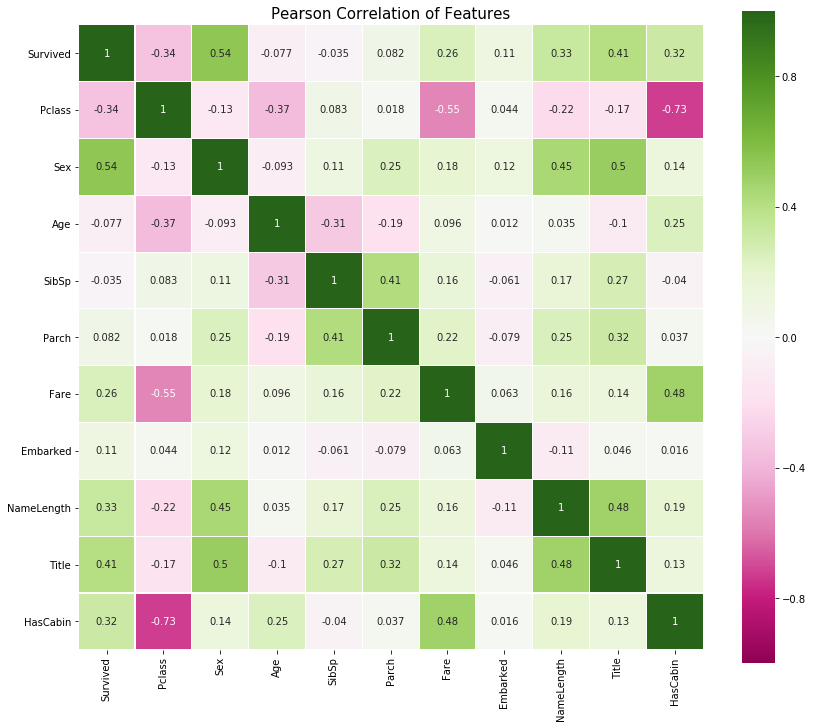

In [147]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1., size=15)
sns.heatmap(train.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0,
            vmin=-1.0,
            square=True,
            cmap=plt.cm.PiYG, # colormap reference: https://matplotlib.org/examples/color/colormaps_reference.html
            linecolor='white',
            annot=True)

Now we will take a look at the same data using pairplot

/Users/dan.park/.virtualenvs/titanic/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/dan.park/.virtualenvs/titanic/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

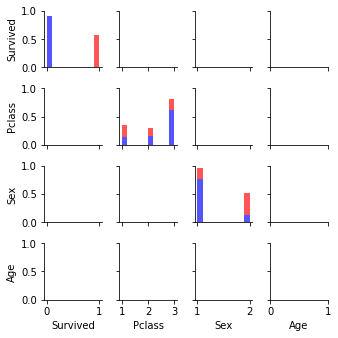

In [28]:
g = sns.pairplot(train[[u'Survived',
                        u'Pclass',
                        u'Sex',
                        u'Age',
#                         u'SibSp',
#                         u'Parch',
#                         u'Fare',
#                         u'Embarked',
#                         u'NameLength',
#                         u'Title',
#                         u'HasCabin'
                       ]],
                 hue='Survived',
                 palette = 'seismic',
                 size=1.2,
                )
# g.set(xticklabels=[])

In [ ]:
# Things to note:
# - sklearn will not run if there are missing data points (like age)

    